The idea here is to buy the whole market at the start of 2009 and leave it until the end.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

def symbol_to_path(symbol, base_dir="AdjDaily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)

        if symbol == 'TASI':  # drop dates SPY did not trad
            df = df.dropna(subset=["TASI"])

    return df

def load_df():
    dates = pd.date_range('01/01/2009', '20/12/2018')
    N= (dates[-1]-dates[0])/365
    N = str(N).split()[0]
    files = os.listdir("AdjDaily")
    symbols=[]
    for name in files:
        if name[0].isdigit():
            symbols.append(name.split('.')[0])
    df = get_data(symbols, dates, 'Close')
    df.to_pickle('database.pkl')
    return df
def normalize_data(df):
    return df/df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1
    daily_returns = daily_returns[1:]
    return daily_returns

def stats(df,period):
    if period == 'W':
        p = 52.0
    if period == 'M':
        p = 12.0
    if period == 'D':
        p = 365.0
    cagr = (df.iloc[-1]/df.iloc[0])**(1.0/(len(df)/p)) - 1.0
    dr = compute_daily_returns(df)
    sharpe = np.sqrt(p) * dr.mean() / dr.std()
    print (' CAGR(%) = ' + str(cagr * 100))
    print (' Sharpe ratio = ' + str(sharpe))

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

def pos_val(df,capital=100000,alloc=[]):
    if alloc == []:
        alloc= 1.0/len(df.columns)
    return (normalize_data(df) * alloc * capital).sum(axis=1)

In [2]:
try:
    df = pd.read_pickle('database.pkl')
except:
    print ('No pkl')
    df = load_df()


In [3]:
df.head()

,TASI,1010,1020,1030,1040,1050,1060,1080,1090,1120,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
2009-01-03,5023.22021,10.88,8.43,10.32,9.54,21.98,22.6,22.25,22.74,54.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,5048.31006,10.83,8.46,10.48,9.44,22.20,23.6,22.00,22.98,54.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,5180.35010,10.90,8.54,10.80,9.44,23.03,24.0,22.25,23.40,55.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,5289.72998,10.90,8.67,11.40,9.54,24.23,24.2,22.80,23.94,57.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,5322.22021,11.00,8.70,10.97,9.59,25.58,24.8,22.80,24.54,58.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.dropna(subset=["TASI"])
tasi = df['TASI'].copy()
df = df.drop('TASI',axis=1)

In [5]:
df.head()

,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
2009-01-03,10.88,8.43,10.32,9.54,21.98,22.6,22.25,22.74,54.00,14.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,10.83,8.46,10.48,9.44,22.20,23.6,22.00,22.98,54.00,14.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,10.90,8.54,10.80,9.44,23.03,24.0,22.25,23.40,55.39,14.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,10.90,8.67,11.40,9.54,24.23,24.2,22.80,23.94,57.92,14.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,11.00,8.70,10.97,9.59,25.58,24.8,22.80,24.54,58.62,14.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mask = df.iloc[0].isnull()
df = df.loc[:,~mask]
mask = df.iloc[0]==0
df = df.loc[:,~mask]
df.head()

,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8120,8130,8140,8150,8160,8170,8180,8190,8200,8210
2009-01-03,10.88,8.43,10.32,9.54,21.98,22.6,22.25,22.74,54.00,14.17,...,20.24,29.9,22.86,14.75,17.16,12.75,6.62,21.55,11.60,4.24
2009-01-04,10.83,8.46,10.48,9.44,22.20,23.6,22.00,22.98,54.00,14.17,...,21.63,32.8,25.14,16.25,17.81,13.25,6.94,19.38,12.47,4.66
2009-01-05,10.90,8.54,10.80,9.44,23.03,24.0,22.25,23.40,55.39,14.27,...,20.68,35.2,25.04,15.60,17.28,13.10,6.81,18.44,12.53,4.56
2009-01-06,10.90,8.67,11.40,9.54,24.23,24.2,22.80,23.94,57.92,14.37,...,22.15,33.3,26.36,16.40,18.94,13.70,7.06,18.39,12.53,4.70
2009-01-07,11.00,8.70,10.97,9.59,25.58,24.8,22.80,24.54,58.62,14.00,...,22.37,31.6,25.30,15.65,18.82,13.60,7.44,19.00,12.41,4.59


In [7]:
alloc= 1.0/len(df.columns)
capital = len(df.columns) * 1000
port = (normalize_data(df) * alloc * capital).sum(axis=1)

In [8]:
port.tail()

2018-03-25    210673.290573
2018-03-26    211348.391049
2018-03-27    212055.043613
2018-03-28    211811.206321
2018-03-29    211173.756869
dtype: float64

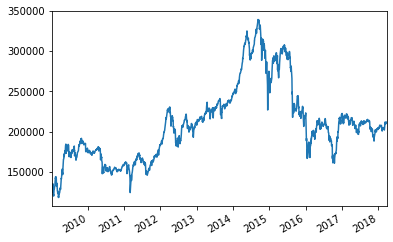

In [9]:
pie = port.plot()

In [10]:
fig = pie.get_figure()
fig.savefig("myplot.png")

In [11]:
df.iloc[0]==0

1010    False
1020    False
1030    False
1040    False
1050    False
1060    False
1080    False
1090    False
1120    False
1140    False
1150    False
1210    False
1211    False
1212    False
1310    False
2001    False
2010    False
2020    False
2030    False
2040    False
2050    False
2060    False
2070    False
2080    False
2090    False
2100    False
2110    False
2120    False
2130    False
2140    False
        ...  
6030    False
6040    False
6050    False
6060    False
6070    False
6090    False
7010    False
7020    False
7030    False
8010    False
8020    False
8030    False
8040    False
8050    False
8060    False
8070    False
8080    False
8090    False
8100    False
8110    False
8120    False
8130    False
8140    False
8150    False
8160    False
8170    False
8180    False
8190    False
8200    False
8210    False
Name: 2009-01-03 00:00:00, Length: 125, dtype: bool

In [16]:
div = pd.read_csv('divdends.csv',index_col='Ticker')

In [17]:
div

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Ticker,,,,,,,,,,,,,,,
1010,22.5,16.0,17.00,18.0,9.60,3.20,2.30,1.30,1.30,1.25,1.40,1.30,1.18,0.70,0.70
1020,0.0,2.5,2.55,3.0,0.60,2.00,0.50,0.50,0.00,0.00,0.50,0.00,0.00,0.00,0.00
1030,8.0,12.0,3.00,3.0,3.00,0.00,0.00,0.00,0.00,0.00,0.50,0.70,0.80,0.80,0.75
1040,27.0,16.5,16.00,16.0,8.35,0.71,0.00,0.75,0.00,0.00,1.00,1.00,1.00,1.00,0.25
1050,14.0,17.5,17.50,20.0,6.50,1.75,0.50,1.00,1.00,1.70,0.00,1.20,0.45,1.00,1.10
1060,17.0,17.0,20.00,20.0,6.50,3.78,3.18,0.83,0.00,0.68,0.65,0.92,1.00,1.45,0.70
1080,11.0,12.0,16.00,9.0,6.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.95,1.00,1.00
1090,23.5,21.5,16.75,10.5,1.70,3.40,1.90,1.65,1.65,1.55,1.65,1.65,1.50,1.15,0.90
1120,28.0,28.0,35.00,50.0,5.00,2.50,1.75,3.00,3.00,2.75,3.25,3.50,2.00,1.25,1.75
